** Newer version at [https://github.com/oduerr/dl_tutorial/tree/master/lasagne] **

# Minimal Lasagne
The python script [load_mnist.py](load_mnist.py) contains functions to load the mnist data. The data is taken from http://deeplearning.net/data/mnist/mnist.pkl.gz. Basically the all images should be provided in a 4-dimensional array X with the following dimensions (number of images, number of colors, x, y) and the labels in a vector y of same size. So X[1,0,1,2] would be the image number 1, the color chanel 0 and the pixel x = 1 and y=2. 

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
from load_mnist import load_data_2d

In [47]:
X,y,PIXELS = load_data_2d('../../data/mnist.pkl.gz')

Loaded data
After Batchnormalization (z-Trafo) Min / Max X / Mean -1.2488 / 66.487 / 8.03533e-10


X contains the images and y contains the labels.

In [48]:
X.shape

(70000, 1, 28, 28)

In [49]:
y.shape

(70000,)

##### Let s plot the first few images and label


In [50]:
y[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

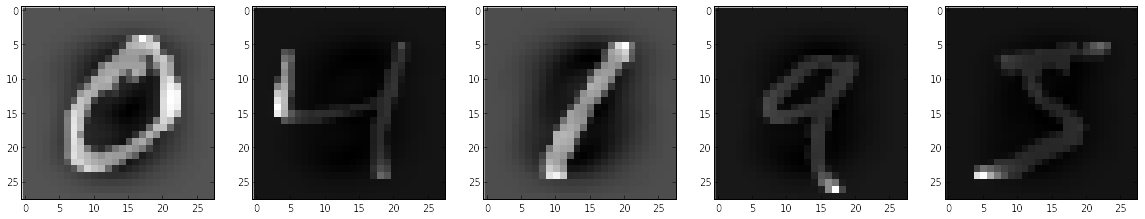

In [51]:
fig = plt.figure(figsize=(20,100))
for i in range(5):
    a=fig.add_subplot(1,5,i)
    plt.imshow(X[i,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))

### Our first Simple Network
Now since we have loaded our data. Let's train a network with it. First we load the necessary libraries and then simply build our network. 
#### Definition of the network
There are serveral ways to define a network. We do the easiest using `NeuralNet` from `nolearn.lasagne`. 

In [52]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    hidden4_num_units=500,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=100,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 
Note that the data is split automatically into 80% Training and 20% Testset. We don't have to take care about this. Since it takes quite a while to finish an epoch (at least with a CPU), we reduce the data to 1000 samples (800 training and 200 testing). Note also that the geometry makes sense the first 3x3 convolution knocks off 2 pixels from the 28x28 images resulting in 26x26 images. Then the maxpooling with size 2x2 reduces these images to 13x13 pixels...

In [ ]:
net = net1.fit(X[0:50000,:,:,:],y[0:50000])

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.354806  |    0.132193  |     2.683998  |     96.03%  |  8.3s
     2  |    0.093475  |    0.091100  |     1.026081  |     97.26%  |  8.3s
     3  |    0.059003  |    0.074875  |     0.788021  |     97.67%  |  8.3s
     4  |    0.041838  |    0.065796  |     0.635877  |     98.00%  |  8.3s
     5  |    0.031173  |    0.060128  |     0.518441  |     98.19%  |  8.3

Note this takes a bit time on a CPU (approx 7 sec) for each epoch. If running on the GPU it onlty takes about 0.2 sec for each epoch.

We have a trained classifier with which we can make predictions.

In [19]:
net.predict(X[3000:3010,:,:,:])

array([9, 0, 9, 8, 1, 3, 2, 5, 7, 4])

**That's basically all we need! ** We can make predictions on new data.

In the following we will show how to store and reload the learned model. The reloaded model can be further trained on novel data.

##### Storing the trained model
We now have a trained model, which we can store using the pickle mechanism as follows

In [20]:
import cPickle as pickle
with open('data/net1.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

In [21]:
%ls -rtlh data

total 12M
-rw-r--r-- 1 dueo dueo 12M Apr 15 00:52 net1.pickle


#### Loading a stored model
We load the model trained model again...

In [22]:
import cPickle as pickle
with open('data/net1.pickle', 'rb') as f:
    net_pretrain = pickle.load(f)

#### Training further (more iterations)
We can now take the net and train it for further iterations. We will see the training loss already picks to the low value from the previous model. So the model is really reloaded.

In [23]:
net_pretrain.fit(X[0:1000,:,:,:],y[0:1000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.141693  |    0.551039  |     0.257137  |     84.42%  |  0.2s
     2  |    0.129509  |    0.552943  |     0.234218  |     84.95%  |  0.2s
     3  |    0.111243  |    0.557282  |     0.199617  |     86.12%  |  0.2s
     4  |    0.095897  |    0.553497  |     0.173256  |     86.51%  |  0.2s
     5  |    0.081135  |    0.555624  |     0.146025  |     86.51%  |  0.2

#### Training further (new data)
We can train also on new data and now on 5 epochs.

In [13]:
net_pretrain.max_epochs = 5
net_pretrain.fit(X[1000:2000,:,:,:],y[1000:2000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.734504  |    1.321238  |     0.555921  |     74.33%  |  0.2s
     2  |    0.327643  |    0.802653  |     0.408200  |     83.06%  |  0.2s
     3  |    0.216492  |    0.676354  |     0.320087  |     86.85%  |  0.2s
     4  |    0.132390  |    0.652336  |     0.202947  |     85.68%  |  0.2s
     5  |    0.098517  |    0.661288  |     0.148977  |     86.07%  |  0.2

### Evaluate the model
We now make predictions on unseen data. We have trained only on the images 0-1999.

In [21]:
preds = net_pretrain.predict(X[3000:3010,:,:,:])
preds, y[3000:3010],X[3000:3010,:,:,:].shape

(array([9, 0, 9, 8, 1, 3, 2, 5, 7, 4]),
 array([9, 0, 8, 8, 1, 3, 2, 5, 7, 4], dtype=int32),
 (10, 1, 28, 28))

Let's look at the correponding images.

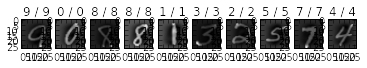

In [15]:
fig = plt.figure()
for i in range(10):
    a=fig.add_subplot(1,10,(i+1)) #NB the one based API sucks!
    a.set_title(str(y[(3000 + i)]) + " / " + str(preds[i]))
    plt.imshow(X[(3000+i),0,:,:], cmap=plt.get_cmap('gray'))